# HA Chapter 8: Exponential Smoothing

In [1]:
#| echo : false
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# | echo : false
pd.set_option('display.max_columns', 10)
plt.rcParams['figure.figsize'] = (10, 6)

---

## Exercise 8.1

Consider the the number of pigs slaughtered in Victoria, available in the aus_livestock dataset.


In [3]:
#| echo : false
#| warning : false
#| message : false

aus_livestock = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_livestock.csv', parse_dates=True, index_col = 'Month')
aus_livestock 

C:\Users\nickc\AppData\Local\Temp\ipykernel_37680\45342766.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aus_livestock = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_livestock.csv', parse_dates=True, index_col = 'Month')


,Unnamed: 0,Animal,State,Count
Month,,,,
1976-07-01,1,"Bulls, bullocks and steers",Australian Capital Territory,2300.0
1976-08-01,2,"Bulls, bullocks and steers",Australian Capital Territory,2100.0
1976-09-01,3,"Bulls, bullocks and steers",Australian Capital Territory,2100.0
1976-10-01,4,"Bulls, bullocks and steers",Australian Capital Territory,1900.0
1976-11-01,5,"Bulls, bullocks and steers",Australian Capital Territory,2100.0
...,...,...,...,...
2018-08-01,29360,Sheep,Western Australia,160600.0
2018-09-01,29361,Sheep,Western Australia,121900.0
2018-10-01,29362,Sheep,Western Australia,134000.0



### Part A

Use the ETS() function to estimate the equivalent model for simple exponential smoothing. Find the optimal values of α and $ℓ_0$, and generate forecasts for the next four months.



In [4]:
# filter data
victorian_pigs = aus_livestock.query('Animal == "Pigs" & State == "Victoria"')[['Count']]

In [5]:
#| warning : false

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(victorian_pigs, trend = 'additive', seasonal = None).fit()

predictions = model.forecast(steps=4) # predict the next 4 time steps

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [6]:
victorian_pigs.tail()

,Count
Month,
2018-08-01,102500.0
2018-09-01,82600.0
2018-10-01,100700.0
2018-11-01,98500.0
2018-12-01,92300.0


In [7]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Count   No. Observations:                  558
Model:             ExponentialSmoothing   SSE                    49759385612.180
Optimized:                         True   AIC                          10222.807
Trend:                         Additive   BIC                          10240.105
Seasonal:                          None   AICC                         10222.960
Seasonal Periods:                  None   Date:                 Wed, 28 Feb 2024
Box-Cox:                          False   Time:                         15:11:44
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3350000                alpha                 True
smoothing_trend            0.02791

The optimal $\alpha = 0.335$ and $l_0 =  1.0843e+05$. 

Having a lower alpha estimates means that the exponential decay is slower and we can expected that the next 4 forecasts will be close in value. 

The forecasts for the next 4 time steps are below.

In [8]:
print(predictions)

2019-01-01    95532.225056
2019-02-01    95637.681211
2019-03-01    95743.137366
2019-04-01    95848.593521
Freq: MS, dtype: float64



### Part B

Compute a 95% prediction interval for the first forecast using  $\hat{y}±1.96s$ where $s$ is the standard deviation of the residuals. Compare your interval with the interval produced by R

In [9]:
# we need to calc only the first forecast 
residuals_std = model.resid.std()

first_forecast = predictions.iloc[0]

margin_of_error = 1.96 * residuals_std

lower_limit = first_forecast - margin_of_error
upper_limit = first_forecast + margin_of_error

print(f'95% Prediction Interval: ({lower_limit:.2f}, {upper_limit:.2f})')


95% Prediction Interval: (77022.62, 114041.83)


Rcode :

```{r}

```{r}
fc |>
  autoplot(tail(vic_pigs, 5)) +
  geom_line(aes(y = .fitted), col="#D55E00",
            data = augment(fit)) +
  labs(y="% of GDP", title="Victorian Pigs") +
  guides(colour = "none")
```

\` \` \`

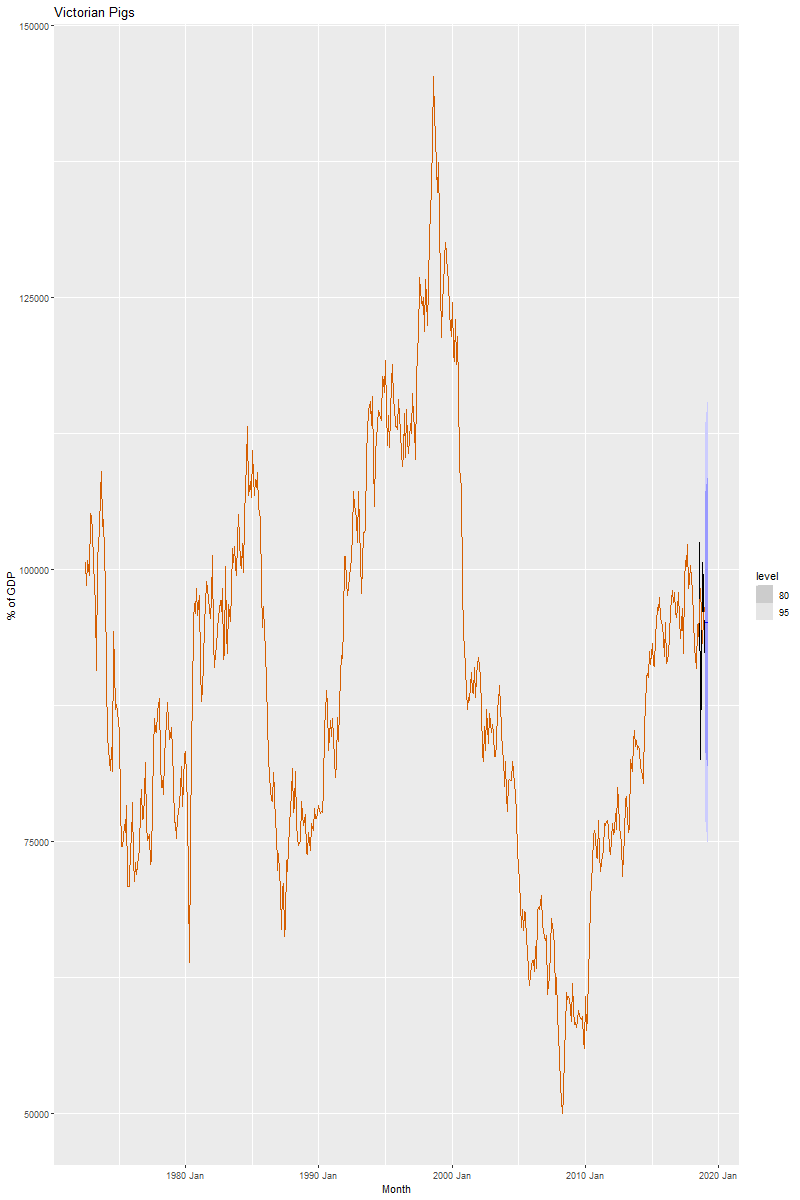

My 95% confidence intervals is narrower compared to the confidence interval produced from the Rcode. We suspect that this may due to different smoothing and leveling estimates.

---

## Exercise 8.5

Data set `global_economy` contains the annual Exports from many countries. Select one country to analyse.

### Part A 

Plot the Exports series and discuss the main features of the data

In [10]:
#|echo : false

global_economy = pd.read_csv("c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/global_economy.csv", parse_dates = ['Year'], index_col = 'Year')


In [28]:
canada_exports = global_economy.query('Country == "Canada"')[['Exports']]

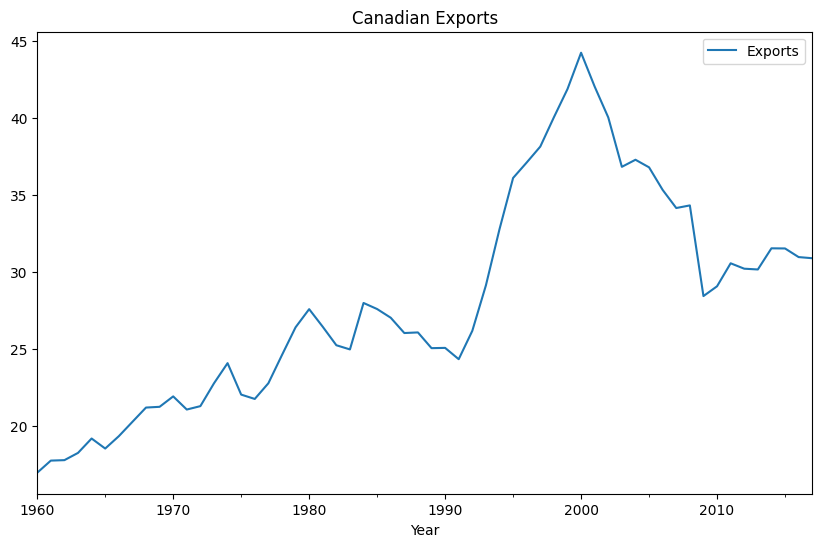

In [44]:
canada_exports.plot()
plt.title('Canadian Exports')
plt.show()

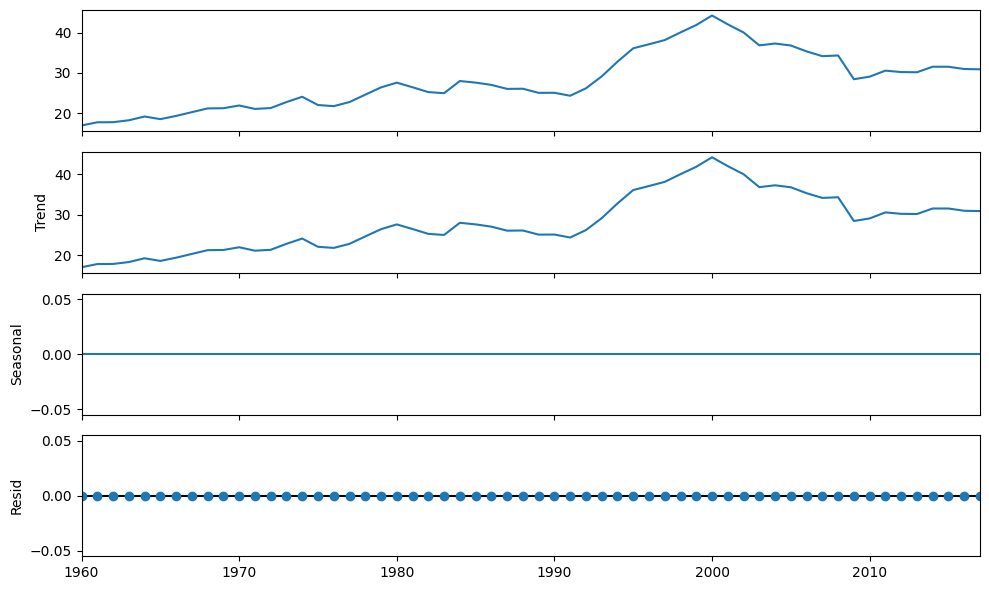

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(canada_exports, model='additive')
result.plot()
plt.show()

Canada's exports exhibits a overall upward trend from 1960 to 2017, with a notable growth during the 1990s. This trend peaked around the year 2000, followed by a decline until 2010 where it started to stabilize. The time series decomposition confirms the absence of seasonality, demosntrating a straight line seasonal component.

### Part B

Use an ETS(A,N,N) model to forecast the series, and plot the forecasts

In [ ]:
# train test split 
train = canada_exports.iloc[len(canada_exports) * 0.8, :]
test = 

In [1]:
model = ExponentialSmoothing(canada_exports, trend = 'additive', seasonal = None).fit()

predictions = model.forecast(steps=4)

NameError: name 'ExponentialSmoothing' is not defined

### Part C

Compute the RMSE values for the training data.

### Part D

Compare the results to those from an ETS(A,A,N) model. (Remember that the trended model is using one more parameter than the simpler model.) Discuss the merits of the two forecasting methods for this data set.

### Part E

Compare the forecasts from both methods. Which do you think is best?

### Part F

Calculate a 95% prediction interval for the first forecast for each model, using the RMSE values and assuming normal errors. Compare your intervals with those produced using R.

***

## Exercise 8.6

Forecast the Chinese GDP from the `global_economy` data set using an ETS model. Experiment with the various options in the ETS() function to see how much the forecasts change with damped trend, or with a Box-Cox transformation. Try to develop an intuition of what each is doing to the forecasts.

[Hint: use a relatively large value of h when forecasting, so you can clearly see the differences between the various options when plotting the forecasts.]

---

## Exercise 8.7

Find an ETS model for the Gas data from `aus_production` and forecast the next few years. Why is multiplicative seasonality necessary here? Experiment with making the trend damped. Does it improve the forecasts?

---

## Exercise 8.8

Recall your retail time series data (from Exercise 7 in Section 2.10).

### Part A

Why is multiplicative seasonality necessary for this series?

### Part B

Apply Holt-Winters’ multiplicative method to the data. Experiment with making the trend damped.

### Part C

Compare the RMSE of the one-step forecasts from the two methods. Which do you prefer?

### Part D

Check that the residuals from the best method look like white noise.

### Part E

Now find the test set RMSE, while training the model to the end of 2010. Can you beat the seasonal naïve approach from Exercise 7 in Section 5.11?

---

## Exercise 8.9

For the same retail data, try an STL decomposition applied to the Box-Cox transformed series, followed by ETS on the seasonally adjusted data. How does that compare with your best previous forecasts on the test set?